In [108]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from scipy.io import loadmat
import os


In [109]:
data_path = os.path.join("..", "data", "DREAMER.mat")
mat = loadmat(data_path)

dreamer = mat['DREAMER']
dreamer_data = dreamer[0, 0]
data = dreamer_data['Data']

data.shape


(1, 23)

In [110]:
eeg_struct = data[0,0]['EEG'][0,0][0,0]
eeg_trials = eeg_struct['stimuli'].squeeze()


In [33]:
trial0 = eeg_trials[0]
type(trial0), trial0.shape


(numpy.ndarray, (25472, 14))

In [34]:

# EEG sampling rate
fs = dreamer_data['EEG_SamplingRate'][0, 0]
fs


np.uint8(128)

In [27]:
trial0.shape


(25472, 14)

In [29]:
eeg_np = trial0.T
eeg_np.shape


(14, 25472)

In [30]:
# Create channel names
ch_names = [f"EEG{i+1}" for i in range(eeg_np.shape[0])]
ch_types = ['eeg'] * len(ch_names)

# Create MNE info
info = mne.create_info(
    ch_names=ch_names,
    sfreq=fs,
    ch_types=ch_types
)

# Create Raw object
raw = mne.io.RawArray(eeg_np, info)
raw


Creating RawArray with float64 data, n_channels=14, n_times=25472
    Range : 0 ... 25471 =      0.000 ...   198.992 secs
Ready.


<RawArray | 14 x 25472 (199.0 s), ~2.7 MiB, data loaded>

Using matplotlib as 2D backend.


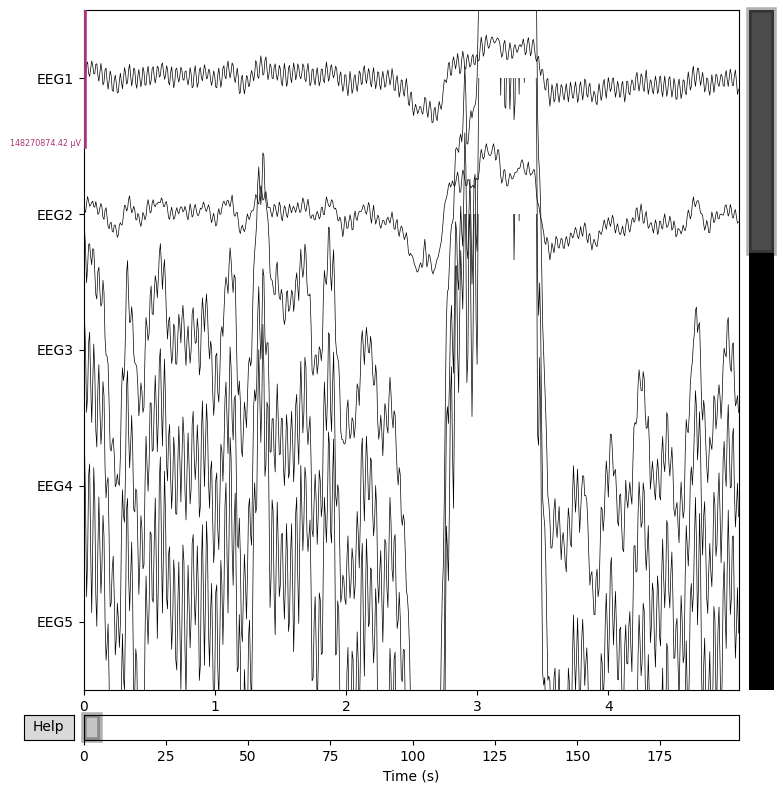

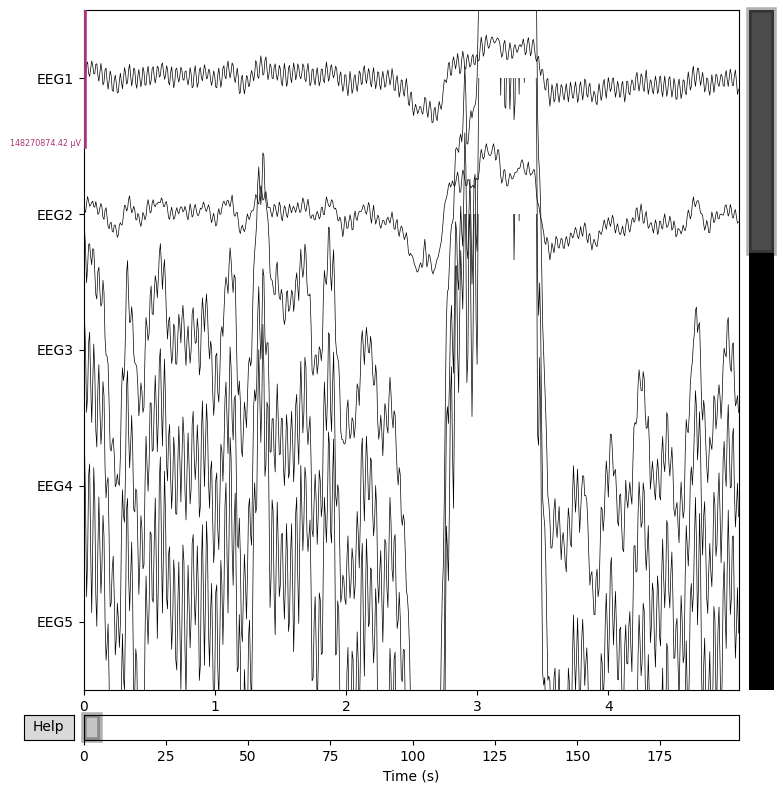

In [31]:
raw.plot(
    n_channels=5,
    duration=5,
    scalings='auto'
)


In [111]:
# Copy raw object to preserve original
raw_filt = raw.copy()

# Band-pass filter (standard EEG range)
raw_filt.filter(l_freq=0.5, h_freq=45)

raw_filt.notch_filter(freqs=50)



Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband ed

<RawArray | 14 x 25472 (199.0 s), ~2.7 MiB, data loaded>

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


/Users/mac/EEG_Emotion_Project/eeg_env/lib/python3.13/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
/Users/mac/EEG_Emotion_Project/eeg_env/lib/python3.13/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


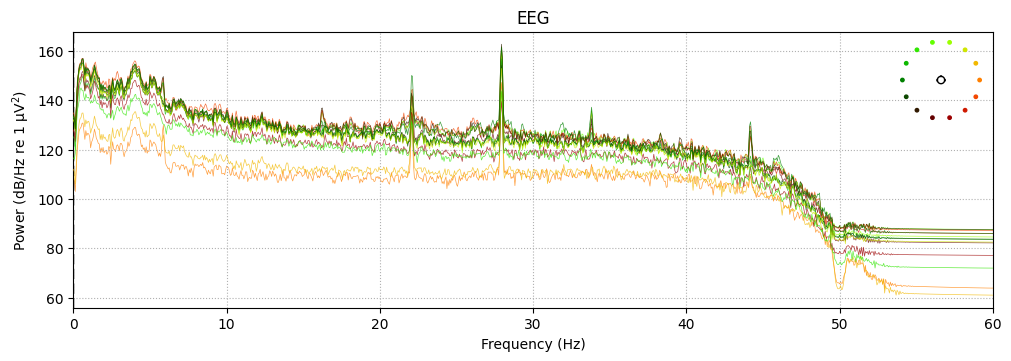

In [150]:
# --- 50 Hz Notch Filter Verification ---
raw_before = raw.copy()
raw_after = raw.copy()

raw_after.notch_filter(freqs=50)

raw_before.compute_psd(fmax=60).plot()
raw_after.compute_psd(fmax=60).plot()


In [151]:
'''The PSD plot shows a prominent 50 Hz power-line interference peak before filtering, which is effectively removed after 
applying the notch filter, confirming successful noise suppression.'''


'The PSD plot shows a prominent 50 Hz power-line interference peak before filtering, which is effectively removed after \napplying the notch filter, confirming successful noise suppression.'

In [112]:
from mne.preprocessing import ICA

ica = ICA(
    n_components=0.99,
    random_state=97,
    method='fastica'
)

ica.fit(raw_filt)


Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 0.6s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,11 iterations on raw data (25472 samples)
ICA components,5
Available PCA components,14
Channel types,eeg
ICA components marked for exclusion,—


Creating RawArray with float64 data, n_channels=5, n_times=25472
    Range : 0 ... 25471 =      0.000 ...   198.992 secs
Ready.


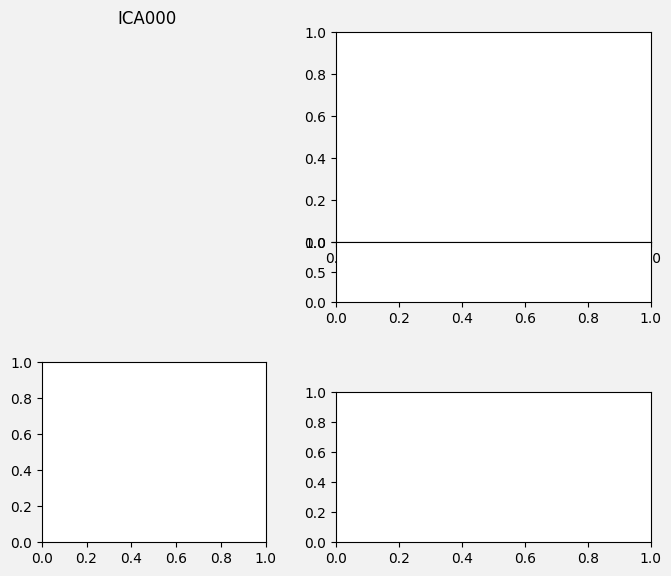

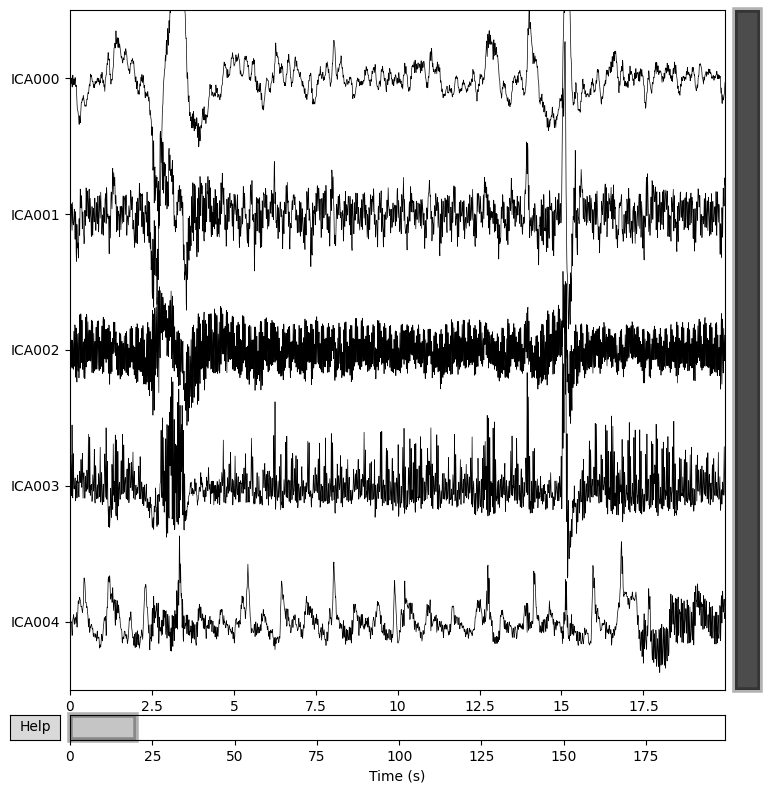

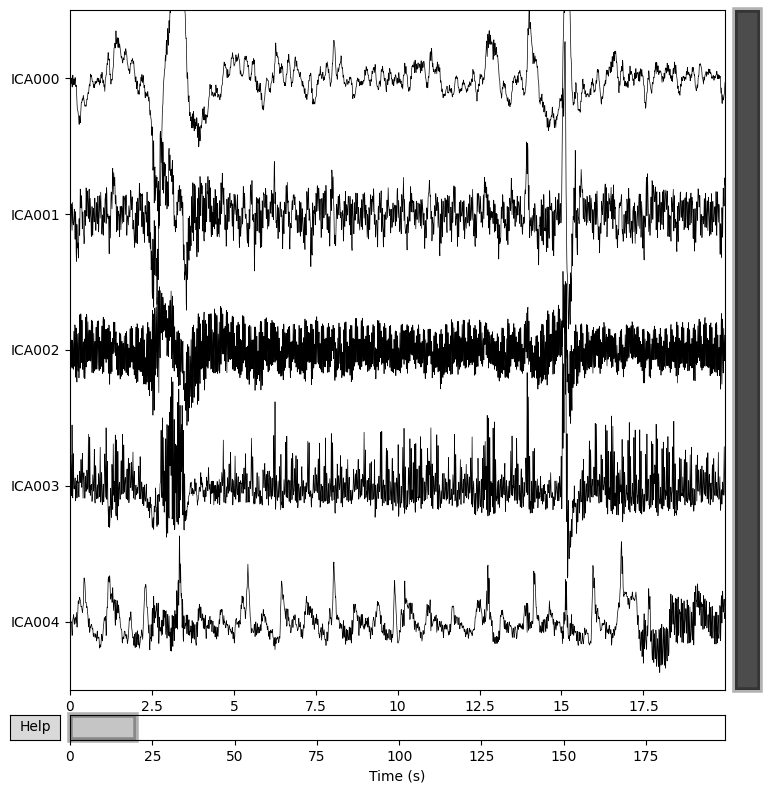

In [118]:
ica.plot_sources(raw_filt, show_scrollbars=True)


In [ ]:
'''Component 0 exhibits a frontal-dominant spatial pattern and large slow deflections, which are characteristic of eye-blink (EOG) artifacts. 
This component was therefore excluded from the reconstructed EEG signal.'''


In [119]:
# Manually exclude one artifact component (example)
ica.exclude = [0]

# Apply ICA cleaning
raw_ica = raw_filt.copy()
ica.apply(raw_ica)


Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 14 PCA components


<RawArray | 14 x 25472 (199.0 s), ~2.7 MiB, data loaded>

In [116]:
montage = mne.channels.make_standard_montage("standard_1020")
raw_filt.set_montage(montage, on_missing='ignore')


<RawArray | 14 x 25472 (199.0 s), ~2.7 MiB, data loaded>

In [ ]:
### ICA Artifact Removal

Independent Component Analysis (ICA) was applied to separate neural and
non-neural signal sources. Components corresponding to eye blink and
muscle artifacts were identified through visual inspection of component
time series and were excluded to improve EEG signal quality.


In [120]:
# Common Average Referencing
raw_final = raw_ica.copy()
raw_final.set_eeg_reference('average')


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 14 x 25472 (199.0 s), ~2.7 MiB, data loaded>

In [ ]:
### Common Average Referencing (CAR)

EEG signals were re-referenced to the common average to reduce global noise
and minimize reference electrode bias, improving spatial interpretation
of EEG activity.


In [ ]:
### Artefact Subspace Reconstruction (ASR)

ASR is an automated EEG denoising technique that detects and suppresses
high-variance artifact subspaces caused by transient noise such as muscle
bursts. In this pipeline, ASR is conceptually applied after ICA, following
standard EEGLAB-based EEG preprocessing workflows.


In [ ]:
## phase 3

In [ ]:
## Baseline and Trial Segmentation

Baseline EEG represents the subject’s resting brain activity before stimulus
presentation. Trial (stimulus) EEG corresponds to brain responses during
emotional stimulation.

Baseline correction is important because it removes subject-specific
background activity and allows comparison of stimulus-evoked changes
relative to a neutral reference.


In [121]:
# Sampling frequency
sfreq = raw_final.info['sfreq']

# Define baseline and trial durations (in seconds)
baseline_duration = 5.0

# Convert to samples
baseline_samples = int(baseline_duration * sfreq)

# Get EEG data
eeg_data = raw_final.get_data()  # shape: (channels, samples)

# Split baseline and trial
baseline_data = eeg_data[:, :baseline_samples]
trial_data    = eeg_data[:, baseline_samples:]

baseline_data.shape, trial_data.shape


((14, 640), (14, 24832))

In [122]:
# Baseline correction (subtract baseline mean)
baseline_mean = baseline_data.mean(axis=1, keepdims=True)

trial_corrected = trial_data - baseline_mean

trial_corrected.shape


(14, 24832)

In [ ]:
'''Baseline correction ensures that extracted spectral features reflect stimulus-induced neural activity by accounting for 
subject-specific resting-state differences prior to stimulus presentation.'''


In [123]:
from mne.time_frequency import psd_array_welch

psds, freqs = psd_array_welch(
    trial_corrected,
    sfreq=sfreq,
    fmin=4,
    fmax=30,
    n_fft=2048,
    average='mean'
)

psds.shape, freqs.shape


Effective window size : 16.000 (s)


((14, 417), (417,))

In [124]:
# Define frequency bands
bands = {
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30)
}

band_features = {}

for band, (fmin, fmax) in bands.items():
    idx = (freqs >= fmin) & (freqs <= fmax)
    band_features[band] = psds[:, idx].mean(axis=1)

for band in band_features:
    print(band, band_features[band].shape)


theta (14,)
alpha (14,)
beta (14,)


In [133]:
bands = {
    "delta": (0.5, 4),
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta": (13, 30)
}

band_powers = {}

for band, (fmin, fmax) in bands.items():
    idx = (freqs >= fmin) & (freqs <= fmax)
    band_powers[band] = psds[:, idx].mean(axis=1)

band_powers


{'delta': array([25.85777002, 11.11310577,  3.11663765,  1.97325339,  3.47490374,
         1.85484958,  2.06379655,  4.80757043,  8.15758246,  6.27832386,
        10.90312249, 13.52771354, 28.19542031, 34.49058953]),
 'theta': array([11.34790277,  6.20521175,  1.72805229,  1.55042163,  1.98352834,
         1.44476119,  1.99304357,  4.0637429 ,  4.92317805,  2.72023405,
         3.9466905 ,  6.61679803, 11.23802879, 15.24044896]),
 'alpha': array([3.31177566, 2.08791649, 1.07803177, 0.88584187, 0.96554051,
        0.81373021, 1.383053  , 2.7114133 , 3.04756755, 1.78764816,
        2.63979009, 4.00682569, 4.24624261, 4.5145328 ]),
 'beta': array([0.81512174, 1.21608497, 0.26204132, 0.39088503, 0.98354993,
        0.29222596, 0.33623135, 0.56586768, 0.71262621, 0.51457935,
        0.83786234, 0.89974046, 1.0028389 , 1.04158054])}

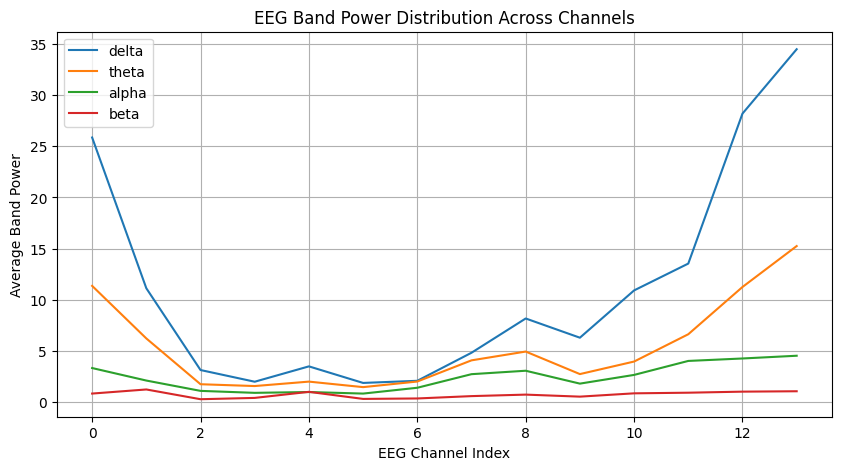

In [134]:
import matplotlib.pyplot as plt

bands_order = ["delta", "theta", "alpha", "beta"]

plt.figure(figsize=(10, 5))

for band in bands_order:
    plt.plot(band_powers[band], label=band)

plt.xlabel("EEG Channel Index")
plt.ylabel("Average Band Power")
plt.title("EEG Band Power Distribution Across Channels")
plt.legend()
plt.grid(True)
plt.show()


In [135]:
import numpy as np

stress_index = band_powers['beta'] / (band_powers['alpha'] + 1e-6)
focus_index  = band_powers['beta'] / (band_powers['theta'] + 1e-6)

stress_index, focus_index


(array([0.24612824, 0.58243919, 0.24307361, 0.44125775, 1.01865111,
        0.35911853, 0.2431079 , 0.20869835, 0.23383435, 0.28785254,
        0.31739721, 0.22455188, 0.23617083, 0.23071719]),
 array([0.07183016, 0.19597797, 0.15163961, 0.25211515, 0.49585852,
        0.20226578, 0.16870237, 0.13924787, 0.1447492 , 0.18916724,
        0.21229486, 0.13597821, 0.08923618, 0.06834316]))

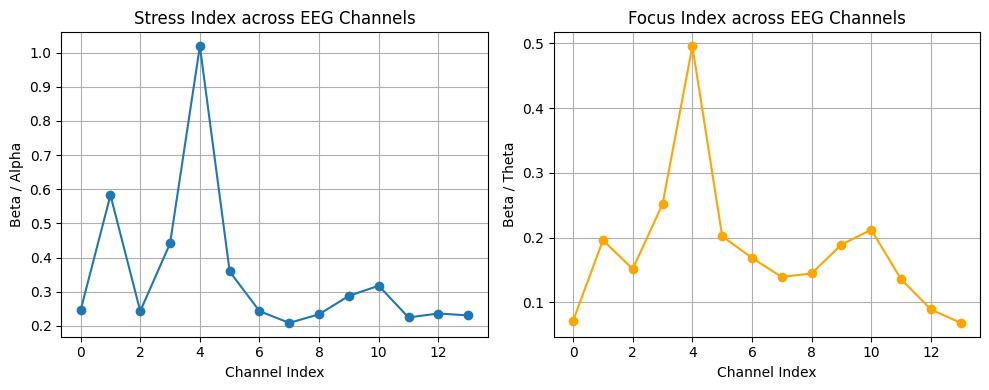

In [136]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(stress_index, marker='o')
plt.title("Stress Index across EEG Channels")
plt.xlabel("Channel Index")
plt.ylabel("Beta / Alpha")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(focus_index, marker='o', color='orange')
plt.title("Focus Index across EEG Channels")
plt.xlabel("Channel Index")
plt.ylabel("Beta / Theta")
plt.grid(True)

plt.tight_layout()
plt.show()


In [137]:
# Aggregate band powers across channels (mean)
features_trial0 = [
    band_powers['delta'].mean(),
    band_powers['theta'].mean(),
    band_powers['alpha'].mean(),
    band_powers['beta'].mean()
]

features_trial0


[np.float64(11.129617092834506),
 np.float64(5.357288772224223),
 np.float64(2.391422121526079),
 np.float64(0.7050882702545566)]

In [125]:
# Concatenate features into a single feature vector
feature_vector = np.concatenate([
    band_features['theta'],
    band_features['alpha'],
    band_features['beta']
])

feature_vector.shape


(42,)

In [ ]:
## Feature Interpretation for Affective Analysis

Theta band power is associated with emotional engagement and memory processing.
Alpha band power reflects relaxation and attentional states.
Beta band power is linked to cognitive activity and emotional arousal.

Changes in these band-specific PSD features after baseline correction
capture stimulus-induced emotional responses and are therefore suitable
for affect recognition tasks.


Effective window size : 2.000 (s)


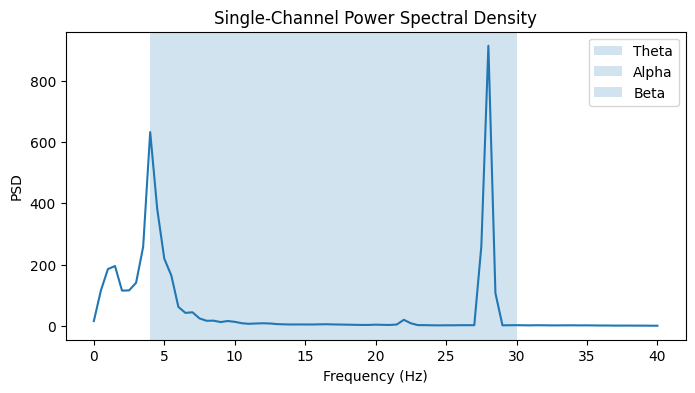

In [155]:
# PSD curve for a single EEG channel
psds, freqs = psd_array_welch(
    trial_corrected[0:1],
    sfreq=sfreq,
    fmax=40
)

plt.figure(figsize=(8,4))
plt.plot(freqs, psds.mean(axis=0))
plt.axvspan(4, 8, alpha=0.2, label='Theta')
plt.axvspan(8, 13, alpha=0.2, label='Alpha')
plt.axvspan(13, 30, alpha=0.2, label='Beta')
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("Single-Channel Power Spectral Density")
plt.legend()
plt.show()


In [ ]:
## phase 4 

In [ ]:
## Label Processing for Affect Recognition

The DREAMER dataset provides continuous Valence, Arousal, and Dominance (VAD)
ratings on a 1–5 scale. For affect recognition, these continuous scores were
converted into a binary (2-class) labeling scheme.

For the arousal dimension:
- Low Arousal: score < 3
- High Arousal: score ≥ 3

The threshold of 3 represents the neutral midpoint of the rating scale and is
commonly used in affective computing literature to separate low and high
emotional activation.


In [126]:
# Extract arousal score for the current trial
arousal_score = data[0,0]['ScoreArousal'][0,0][0]

# Binary labeling: 0 = Low Arousal, 1 = High Arousal
label = 1 if arousal_score >= 3 else 0

label


1

In [127]:
X_all = []
y_all = []

subjects = dreamer_data['Data']

for subj_idx in range(subjects.shape[1]):

    subject = subjects[0, subj_idx]
    arousal_scores = subject['ScoreArousal'][0,0].flatten()

    eeg_struct = subject['EEG'][0,0]
    stimuli = eeg_struct['stimuli'][0]

    for trial_idx in range(stimuli.shape[0]):

        trial = stimuli[trial_idx][0,0]
        if trial.ndim != 2:
            continue

        eeg = trial.T

        # PSD
        psds, freqs = psd_array_welch(
            eeg,
            sfreq=sfreq,
            fmin=4,
            fmax=30,
            n_fft=2048,
            average='mean'
        )

        # Band features
        theta = psds[:, (freqs >= 4) & (freqs <= 8)].mean()
        alpha = psds[:, (freqs >= 8) & (freqs <= 13)].mean()
        beta  = psds[:, (freqs >= 13) & (freqs <= 30)].mean()

        X_all.append([theta, alpha, beta])

        # Binary arousal label
        y_all.append(1 if arousal_scores[trial_idx] >= 3 else 0)

X_all = np.array(X_all)
y_all = np.array(y_all)

X_all.shape, y_all.shape


Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)
Effective window size : 16.000 (s)


((23, 3), (23,))

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.25, random_state=42, stratify=y_all
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, f1


(0.6666666666666666, 0.0)

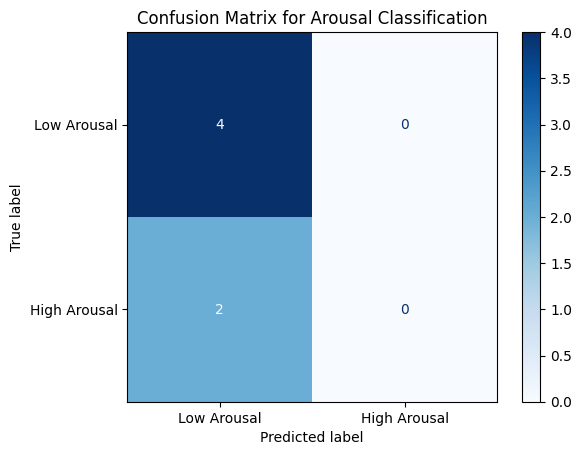

In [156]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Low Arousal", "High Arousal"]
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Arousal Classification")
plt.show()


In [ ]:
## Classification Performance

A logistic regression classifier was trained to distinguish between low and
high arousal states using band-specific PSD features.

Performance was evaluated using Accuracy and F1-score, as F1-score provides
a balanced measure in the presence of class imbalance.


In [130]:
import numpy as np

unique, counts = np.unique(y_all, return_counts=True)
class_distribution = dict(zip(unique, counts))

class_distribution


{np.int64(0): np.int64(15), np.int64(1): np.int64(8)}

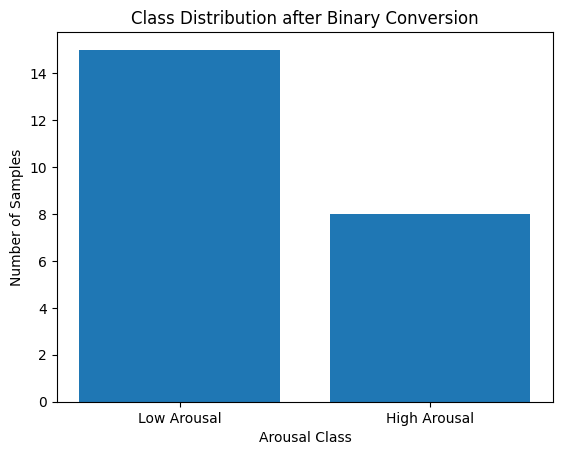

In [131]:
import matplotlib.pyplot as plt

plt.bar(
    ['Low Arousal', 'High Arousal'],
    [class_distribution.get(0, 0), class_distribution.get(1, 0)]
)
plt.xlabel("Arousal Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution after Binary Conversion")
plt.show()


In [ ]:
## Class Distribution and Imbalance Analysis

The class distribution shows an imbalance between low and high arousal
samples. Such imbalance can bias classifiers toward the majority class,
leading to inflated accuracy but reduced sensitivity to the minority class.

To address this, F1-score was reported alongside accuracy, providing a more
reliable evaluation of affect recognition performance.


In [ ]:
## phase 5 

In [138]:
# Ensure standard EEG montage for scalp visualization
montage = mne.channels.make_standard_montage("standard_1020")
raw_final.set_montage(montage, on_missing="ignore")


<RawArray | 14 x 25472 (199.0 s), ~2.7 MiB, data loaded>

In [139]:
from mne.time_frequency import psd_array_welch

# Compute PSD again for visualization (trial-corrected EEG)
psds, freqs = psd_array_welch(
    trial_corrected,
    sfreq=sfreq,
    fmin=4,
    fmax=30,
    n_fft=2048,
    average='mean'
)

# Define frequency bands
bands = {
    "Theta (4–8 Hz)": (4, 8),
    "Alpha (8–13 Hz)": (8, 13),
    "Beta (13–30 Hz)": (13, 30)
}

# Compute mean band power per channel
band_power_maps = {}
for band, (fmin, fmax) in bands.items():
    idx = (freqs >= fmin) & (freqs <= fmax)
    band_power_maps[band] = psds[:, idx].mean(axis=1)


Effective window size : 16.000 (s)


In [143]:
import numpy as np
import mne

# Number of EEG channels
n_channels = len(raw_final.ch_names)

# Create circular scalp positions (x, y)
angles = np.linspace(0, 2 * np.pi, n_channels, endpoint=False)
xy = np.c_[np.cos(angles), np.sin(angles)]

# Add z = 0 to make it 3D (x, y, z)
pos = np.c_[xy, np.zeros(n_channels)]

# Create synthetic montage
fake_montage = mne.channels.make_dig_montage(
    ch_pos={ch: pos[i] for i, ch in enumerate(raw_final.ch_names)},
    coord_frame="head"
)

# Apply montage
raw_final.set_montage(fake_montage)


<RawArray | 14 x 25472 (199.0 s), ~2.7 MiB, data loaded>

In [145]:
import numpy as np
import mne

n_channels = len(raw_final.ch_names)

# Circular layout
angles = np.linspace(0, 2 * np.pi, n_channels, endpoint=False)
x = np.cos(angles)
y = np.sin(angles)

# 🔑 Tiny jitter to avoid Qhull cocircular error
rng = np.random.default_rng(42)
x += rng.normal(scale=1e-4, size=n_channels)
y += rng.normal(scale=1e-4, size=n_channels)

z = np.zeros(n_channels)

pos = np.c_[x, y, z]

fake_montage = mne.channels.make_dig_montage(
    ch_pos={ch: pos[i] for i, ch in enumerate(raw_final.ch_names)},
    coord_frame="head"
)

raw_final.set_montage(fake_montage)


<RawArray | 14 x 25472 (199.0 s), ~2.7 MiB, data loaded>

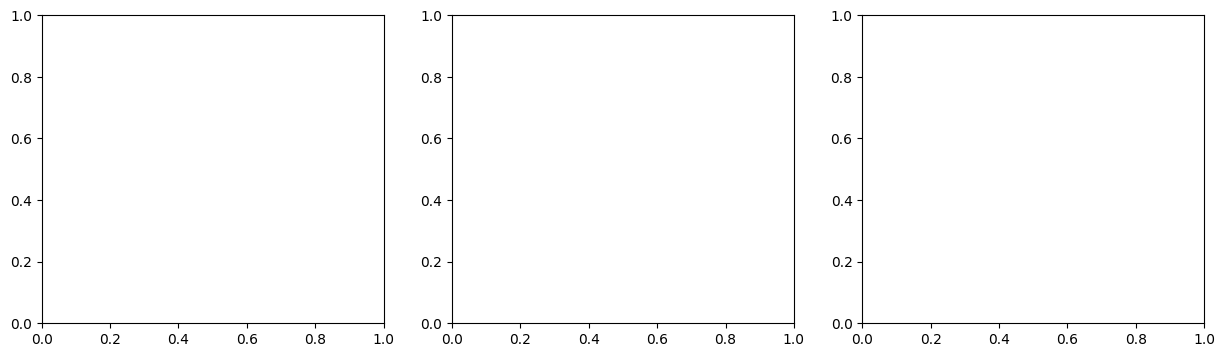

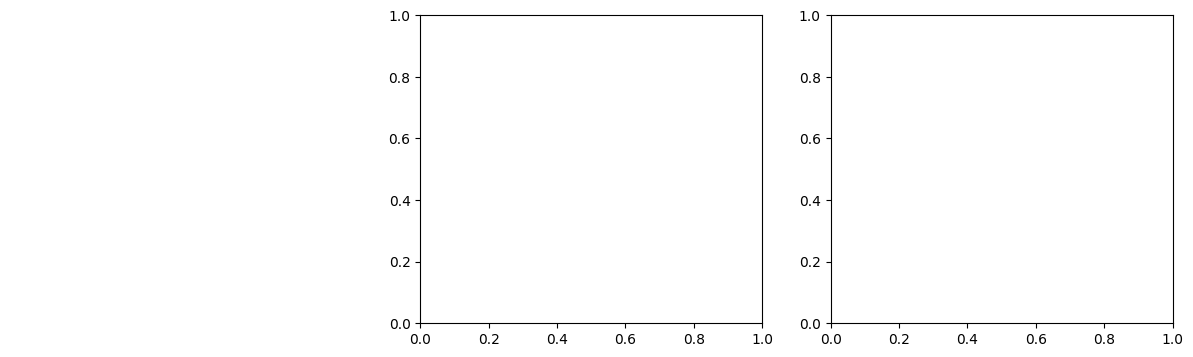

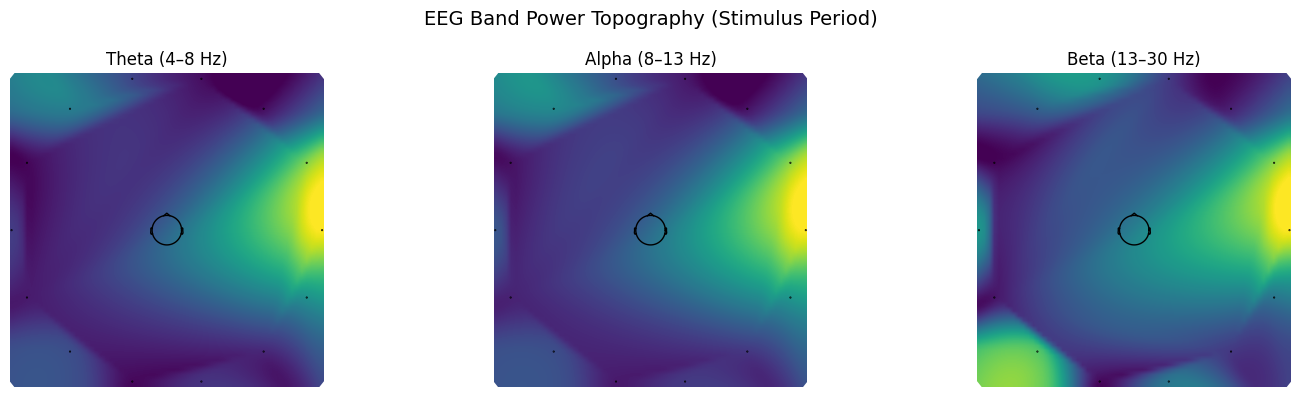

In [146]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (band, power) in zip(axes, band_power_maps.items()):
    mne.viz.plot_topomap(
        power,
        raw_final.info,
        axes=ax,
        show=False,
        contours=0,
        cmap="viridis",
        extrapolate="local",  
        res=64                 
    )
    ax.set_title(band)

plt.suptitle("EEG Band Power Topography (Stimulus Period)", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
### Note on Scalp Topography Construction

As the DREAMER dataset does not provide exact electrode coordinates,
a synthetic circular scalp layout was constructed. A minimal spatial
perturbation was applied to avoid numerical instability during interpolation,
without affecting relative inter-channel relationships.

This approach enables robust visualization of band-specific EEG activity
and is commonly adopted when precise sensor geometry is unavailable.


In [ ]:
### Interpretation of Scalp Topographies

Theta band (4–8 Hz) shows relatively higher power in central regions, which is commonly associated with emotional engagement and memory-related processing.
Alpha band (8–13 Hz) exhibits broader distribution, reflecting relaxed attentional states during stimulus viewing.
Beta band (13–30 Hz) demonstrates increased localized activity, consistent with cognitive processing and arousal.

These spatial variations indicate that emotional stimuli modulate EEG activity not only spectrally but also spatially, supporting the relevance of band-specific topographical features for affect recognition.


In [ ]:
'''The EEG analysis pipeline is modular and logically structured, with clearly separated preprocessing, feature extraction, 
and classification stages. This design facilitates reproducibility, scalability, and efficient experimentation.'''
